In [1]:
import pandas as pd
import numpy as np
import skmob
from tqdm import tqdm
import geohash2
import matplotlib.pyplot as plt
import datetime
import seaborn as sn

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Some statistics per user

In [2]:
geolife = pd.read_parquet('geolife_sm.parquet')

In [3]:
geolife.head()

,datetime,lat,lng,tid,label,uid,is_a_stop
0,2009-04-12 07:33:03,40.000017,116.327479,0_000,0,0,0
1,2009-04-12 07:33:09,40.000168,116.327474,0_000,0,0,0
2,2009-04-12 07:33:14,40.000055,116.327454,0_000,0,0,0
3,2009-04-12 07:33:19,40.000021,116.327407,0_000,0,0,0
4,2009-04-12 07:33:24,40.000035,116.327281,0_000,0,0,0


In [4]:
trajs = geolife.groupby(['uid','tid']).datetime.agg(time_max='max', time_min='min')

In [5]:
trajs['duration'] = (trajs['time_max'] - trajs['time_min'])

In [6]:
trajs.head()

time_max            time_min        duration
uid tid                                                            
0   0_000   2009-04-12 17:24:59 2009-04-12 07:33:03 0 days 09:51:56
    100_000 2009-05-07 10:51:39 2009-05-07 02:42:01 0 days 08:09:38
    101_000 2009-05-20 13:03:10 2009-05-20 12:55:35 0 days 00:07:35
    102_000 2009-04-04 14:35:09 2009-04-03 01:16:57 1 days 13:18:12
    103_000 2008-12-12 06:42:47 2008-12-12 04:25:25 0 days 02:17:22

In [7]:
trajs['duration'] = trajs['duration']#.dt.total_seconds()/(3600.0)

In [8]:
trajs.head()

time_max            time_min        duration
uid tid                                                            
0   0_000   2009-04-12 17:24:59 2009-04-12 07:33:03 0 days 09:51:56
    100_000 2009-05-07 10:51:39 2009-05-07 02:42:01 0 days 08:09:38
    101_000 2009-05-20 13:03:10 2009-05-20 12:55:35 0 days 00:07:35
    102_000 2009-04-04 14:35:09 2009-04-03 01:16:57 1 days 13:18:12
    103_000 2008-12-12 06:42:47 2008-12-12 04:25:25 0 days 02:17:22

In [9]:
trajs = pd.DataFrame(trajs.groupby('uid').duration.sum())

In [10]:
trajs.head()

,duration
uid,
0,38 days 15:43:29
1,13 days 03:05:30
2,29 days 04:49:38
3,90 days 09:44:35
4,106 days 06:52:31


In [11]:
stops = pd.read_parquet('geolife_stop.parquet')

In [12]:
trajs['num_stop'] = pd.DataFrame(stops.groupby('uid')['datetime'].count())

In [13]:
trajs.head()

,duration,num_stop
uid,,
0,38 days 15:43:29,431.0
1,13 days 03:05:30,100.0
2,29 days 04:49:38,284.0
3,90 days 09:44:35,971.0
4,106 days 06:52:31,1174.0


In [14]:
len(stops)

19495

In [15]:
stops.head()

,datetime,lat,lng,tid,label,uid,leaving_datetime
0,2009-04-12 08:46:59,39.762700,116.297346,0_000,0,0,2009-04-12 13:06:20
1,2009-04-12 14:10:25,39.999846,116.327148,0_000,0,0,2009-04-12 17:16:44
2,2009-05-07 02:47:36,39.999854,116.327485,100_000,0,0,2009-05-07 03:21:39
3,2009-05-07 03:52:45,39.999919,116.325903,100_000,0,0,2009-05-07 04:53:43
4,2009-05-07 04:58:03,40.007622,116.319384,100_000,0,0,2009-05-07 05:22:04


## Finding systematic stop points

In [16]:
stops['pos_hashed'] = stops[['lat','lng']].apply(lambda x: geohash2.encode(x[0],x[1],7),raw=True,axis=1)

In [17]:
stops.head()

,datetime,lat,lng,tid,label,uid,leaving_datetime,pos_hashed
0,2009-04-12 08:46:59,39.762700,116.297346,0_000,0,0,2009-04-12 13:06:20,wx4dnqt
1,2009-04-12 14:10:25,39.999846,116.327148,0_000,0,0,2009-04-12 17:16:44,wx4ex1d
2,2009-05-07 02:47:36,39.999854,116.327485,100_000,0,0,2009-05-07 03:21:39,wx4ex1g
3,2009-05-07 03:52:45,39.999919,116.325903,100_000,0,0,2009-05-07 04:53:43,wx4ex1c
4,2009-05-07 04:58:03,40.007622,116.319384,100_000,0,0,2009-05-07 05:22:04,wx4ewgj


In [18]:
stops['frequency'] = 0

In [19]:
stops.head()

,datetime,lat,lng,tid,label,uid,leaving_datetime,pos_hashed,frequency
0,2009-04-12 08:46:59,39.762700,116.297346,0_000,0,0,2009-04-12 13:06:20,wx4dnqt,0
1,2009-04-12 14:10:25,39.999846,116.327148,0_000,0,0,2009-04-12 17:16:44,wx4ex1d,0
2,2009-05-07 02:47:36,39.999854,116.327485,100_000,0,0,2009-05-07 03:21:39,wx4ex1g,0
3,2009-05-07 03:52:45,39.999919,116.325903,100_000,0,0,2009-05-07 04:53:43,wx4ex1c,0
4,2009-05-07 04:58:03,40.007622,116.319384,100_000,0,0,2009-05-07 05:22:04,wx4ewgj,0


In [20]:
def compute_freq(x):
    
    freqs = x.groupby('pos_hashed').count()['frequency']
    
    return freqs

In [23]:
systematic_sp = pd.DataFrame(stops.groupby('uid').apply(lambda x: compute_freq(x)))

In [24]:
systematic_sp.head()

frequency
uid pos_hashed           
0   wtw0fx9             1
    wtw0fxf             1
    wtw1482             1
    wtw1483             1
    wtw33pn             1

In [25]:
sp = stops.copy()

In [26]:
sp.set_index(['uid','pos_hashed'],inplace=True)

In [27]:
len(sp)

19495

In [28]:
sp['frequency'] = systematic_sp['frequency']

In [29]:
sp.head()

datetime        lat         lng      tid  label  \
uid pos_hashed                                                              
0   wx4dnqt    2009-04-12 08:46:59  39.762700  116.297346    0_000      0   
    wx4ex1d    2009-04-12 14:10:25  39.999846  116.327148    0_000      0   
    wx4ex1g    2009-05-07 02:47:36  39.999854  116.327485  100_000      0   
    wx4ex1c    2009-05-07 03:52:45  39.999919  116.325903  100_000      0   
    wx4ewgj    2009-05-07 04:58:03  40.007622  116.319384  100_000      0   

                  leaving_datetime  frequency  
uid pos_hashed                                 
0   wx4dnqt    2009-04-12 13:06:20          5  
    wx4ex1d    2009-04-12 17:16:44         10  
    wx4ex1g    2009-05-07 03:21:39         12  
    wx4ex1c    2009-05-07 04:53:43          2  
    wx4ewgj    2009-05-07 05:22:04         33

In [30]:
sp.reset_index(inplace=True)

In [31]:
sp

,uid,pos_hashed,datetime,lat,lng,tid,label,leaving_datetime,frequency
0,0,wx4dnqt,2009-04-12 08:46:59,39.762700,116.297346,0_000,0,2009-04-12 13:06:20,5
1,0,wx4ex1d,2009-04-12 14:10:25,39.999846,116.327148,0_000,0,2009-04-12 17:16:44,10
2,0,wx4ex1g,2009-05-07 02:47:36,39.999854,116.327485,100_000,0,2009-05-07 03:21:39,12
3,0,wx4ex1c,2009-05-07 03:52:45,39.999919,116.325903,100_000,0,2009-05-07 04:53:43,2
4,0,wx4ewgj,2009-05-07 04:58:03,40.007622,116.319384,100_000,0,2009-05-07 05:22:04,33
...,...,...,...,...,...,...,...,...,...
19490,181,wx4ex0j,2007-12-07 10:28:08,39.991550,116.331417,5_181,0,2007-12-07 13:44:22,1
19491,181,wx4eqxw,2008-01-01 02:33:37,39.988375,116.309792,7_181,0,2008-01-01 03:01:38,1
19492,181,wx4erep,2008-01-01 03:25:40,39.963533,116.354900,7_181,0,2008-01-01 05:52:01,1
19493,181,wx4erfd,2008-01-01 05:58:28,39.961317,116.359150,7_181,0,2008-01-01 06:34:42,1


In [62]:
systematic_stops = sp[sp['frequency']>2]

## Systematic stop clustering

In [33]:
from tensorflow.keras.utils import to_categorical

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.metrics.dtw_variants import pairwise_distances
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

### Data preparation

In [34]:
len(systematic_stops)

8561

In [35]:
#systematic_stops['datetime'] += timedelta(hours=8)

In [36]:
#systematic_stops['leaving_datetime'] += timedelta(hours=8)

In [63]:
systematic_stops['start_time'] = systematic_stops['datetime'].dt.hour

/var/folders/8b/yb9kppjj0_3fnvw_py8lgrdh0000gp/T/ipykernel_1751/250624173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  systematic_stops['start_time'] = systematic_stops['datetime'].dt.hour


In [64]:
systematic_stops['end_time'] = systematic_stops['leaving_datetime'].dt.hour

/var/folders/8b/yb9kppjj0_3fnvw_py8lgrdh0000gp/T/ipykernel_1751/3258167287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  systematic_stops['end_time'] = systematic_stops['leaving_datetime'].dt.hour


In [65]:
systematic_stops.reset_index(inplace=True)

In [66]:
systematic_stops.drop(columns=['index'],inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [67]:
systematic_stops.head()

,uid,pos_hashed,datetime,lat,lng,tid,label,leaving_datetime,frequency,start_time,end_time
0,0,wx4dnqt,2009-04-12 08:46:59,39.762700,116.297346,0_000,0,2009-04-12 13:06:20,5,8,13
1,0,wx4ex1d,2009-04-12 14:10:25,39.999846,116.327148,0_000,0,2009-04-12 17:16:44,10,14,17
2,0,wx4ex1g,2009-05-07 02:47:36,39.999854,116.327485,100_000,0,2009-05-07 03:21:39,12,2,3
3,0,wx4ewgj,2009-05-07 04:58:03,40.007622,116.319384,100_000,0,2009-05-07 05:22:04,33,4,5
4,0,wx4ewgj,2009-05-07 05:22:04,40.007261,116.319841,100_000,0,2009-05-07 06:35:41,33,5,6


In [223]:
df = pd.DataFrame(np.zeros((len(systematic_stops),24)))

In [224]:
df['uid'] = systematic_stops['uid']

In [225]:
df['location'] = systematic_stops['pos_hashed']

In [226]:
df.drop_duplicates(['uid','location'],inplace=True)

In [227]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,uid,location
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4dnqt
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ex1d
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ex1g
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ewgj
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ex4c


In [228]:
len(df)

1027

In [229]:
global df

In [230]:
def update_hour(x):
    
    start_col = x[-2]
    end_col = x[-1]
    
    start_raw = df[(df['uid']==x[0])&(df['location']==x[1])].first_valid_index()
    end_raw = start_raw+1
    
    if start_col<end_col:
        
        df.loc[start_raw:end_raw,start_col:end_col] += 1
    
    elif start_col==end_col:
        
        df.loc[start_raw:end_raw,start_col] += 1
        
    else:
        
        df.loc[start_raw:end_raw,start_col:23] += 1
        df.loc[start_raw:end_raw,0:end_col] += 1

In [232]:
systematic_stops.apply(lambda x: update_hour(x),raw=True,axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
8556    None
8557    None
8558    None
8559    None
8560    None
Length: 8561, dtype: object

In [233]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,uid,location
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,wx4dnqt
1,1.0,1.0,2.0,2.0,2.0,1.0,4.0,7.0,10.0,9.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,wx4ex1d
2,1.0,3.0,5.0,5.0,4.0,4.0,9.0,12.0,12.0,8.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ex1g
3,3.0,9.0,8.0,8.0,11.0,12.0,12.0,12.0,14.0,9.0,...,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0,wx4ewgj
7,0.0,0.0,0.0,2.0,6.0,6.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,wx4ex4c


In [234]:
df_freq = df.copy()

In [235]:
hours = [i for i in range(0,24)]

In [236]:
#df['norm'] = df[hours].apply(lambda x: np.sqrt(x.dot(x)), axis=1)

In [237]:
#df[hours] = df[hours].apply(lambda x: x/np.sqrt(x.dot(x)), axis=1)

In [238]:
df['sum'] = df[hours].sum(axis=1)

In [239]:
df.set_index('uid',inplace=True)

In [240]:
df['tot'] = df.groupby('uid')['sum'].sum()

In [241]:
df['importance'] = df['sum'] / df['tot']

In [242]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,location,sum,tot,importance
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,wx4dnqt,31.0,1036.0,0.029923
0,1.0,1.0,2.0,2.0,2.0,1.0,4.0,7.0,10.0,9.0,...,0.0,0.0,0.0,0.0,1.0,1.0,wx4ex1d,68.0,1036.0,0.065637
0,1.0,3.0,5.0,5.0,4.0,4.0,9.0,12.0,12.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,wx4ex1g,78.0,1036.0,0.075290
0,3.0,9.0,8.0,8.0,11.0,12.0,12.0,12.0,14.0,9.0,...,2.0,2.0,1.0,1.0,2.0,2.0,wx4ewgj,132.0,1036.0,0.127413
0,0.0,0.0,0.0,2.0,6.0,6.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,wx4ex4c,22.0,1036.0,0.021236


In [243]:
df.reset_index(inplace=True)

In [244]:
df.set_index(['uid','location'],inplace=True)

In [245]:
df.drop(columns=['sum','tot'],inplace=True)

In [246]:
df.head()

0    1    2    3     4     5     6     7     8    9  ...   15  \
uid location                                                         ...        
0   wx4dnqt   1.0  1.0  1.0  1.0   1.0   0.0   0.0   0.0   4.0  4.0  ...  0.0   
    wx4ex1d   1.0  1.0  2.0  2.0   2.0   1.0   4.0   7.0  10.0  9.0  ...  1.0   
    wx4ex1g   1.0  3.0  5.0  5.0   4.0   4.0   9.0  12.0  12.0  8.0  ...  1.0   
    wx4ewgj   3.0  9.0  8.0  8.0  11.0  12.0  12.0  12.0  14.0  9.0  ...  0.0   
    wx4ex4c   0.0  0.0  0.0  2.0   6.0   6.0   1.0   2.0   2.0  2.0  ...  0.0   

               16   17   18   19   20   21   22   23  importance  
uid location                                                      
0   wx4dnqt   0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0    0.029923  
    wx4ex1d   1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0    0.065637  
    wx4ex1g   1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.075290  
    wx4ewgj   1.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0    0.127413  
    wx4ex4c   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.021236  

[5 rows x 25 columns]

In [247]:
df['night'] = df[[23,0,1,2,3,4,5]].sum(axis=1)

In [248]:
df['morning'] = df[[6,7,8,9,10,11,12]].sum(axis=1)

In [249]:
df['afternoon'] = df[[13,14,15,16,17,18]].sum(axis=1)

In [250]:
df['evening'] = df[[19,20,21,22]].sum(axis=1)

In [251]:
#df['entropy'] = -(df['importance']*np.log(df['importance']))

In [252]:
df.head()

0    1    2    3     4     5     6     7     8    9  ...   19  \
uid location                                                         ...        
0   wx4dnqt   1.0  1.0  1.0  1.0   1.0   0.0   0.0   0.0   4.0  4.0  ...  0.0   
    wx4ex1d   1.0  1.0  2.0  2.0   2.0   1.0   4.0   7.0  10.0  9.0  ...  0.0   
    wx4ex1g   1.0  3.0  5.0  5.0   4.0   4.0   9.0  12.0  12.0  8.0  ...  0.0   
    wx4ewgj   3.0  9.0  8.0  8.0  11.0  12.0  12.0  12.0  14.0  9.0  ...  2.0   
    wx4ex4c   0.0  0.0  0.0  2.0   6.0   6.0   1.0   2.0   2.0  2.0  ...  0.0   

               20   21   22   23  importance  night  morning  afternoon  \
uid location                                                              
0   wx4dnqt   0.0  0.0  1.0  1.0    0.029923    6.0     20.0        4.0   
    wx4ex1d   0.0  0.0  1.0  1.0    0.065637   10.0     47.0       10.0   
    wx4ex1g   0.0  0.0  0.0  0.0    0.075290   22.0     50.0        6.0   
    wx4ewgj   1.0  1.0  2.0  2.0    0.127413   53.0     64.0        9.0   
    wx4ex4c   0.0  0.0  0.0  0.0    0.021236   14.0      8.0        0.0   

              evening  
uid location           
0   wx4dnqt       1.0  
    wx4ex1d       1.0  
    wx4ex1g       0.0  
    wx4ewgj       6.0  
    wx4ex4c       0.0  

[5 rows x 29 columns]

In [253]:
largest = pd.DataFrame(df.groupby('uid')['importance'].nlargest(2))

In [254]:
largest.index = largest.index.droplevel(0)

In [255]:
df['home'] = 0

In [256]:
df['work'] = 0

In [257]:
df['other'] = 0

In [259]:
largest_index = largest.index

In [267]:
w_home = [0.6,0.1,0.1,0.4]

In [268]:
w_work = [0.1,0.6,0.4,0.1]

In [274]:
df['p_home'] = (df[['night','morning','afternoon','evening']].loc[largest.index] * w_home).sum(axis=1)

In [275]:
df['p_work'] = (df[['night','morning','afternoon','evening']].loc[largest.index] * w_work).sum(axis=1)

In [276]:
df['home'] = df['p_home'] / df[['p_home','p_work']].sum(axis=1)

In [278]:
df['work'] = df['p_work'] / df[['p_home','p_work']].sum(axis=1)

In [285]:
df.fillna(0,inplace=True)

In [286]:
df.loc[168]

,0,1,2,3,4,5,6,7,8,9,...,importance,night,morning,afternoon,evening,home,work,other,p_home,p_work
location,,,,,,,,,,,,,,,,,,,,,
wx4dz94,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.151515,5.0,0.0,0.0,0.0,0.00000,0.00000,1,0.0,0.0
wx4gbvg,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.515152,4.0,2.0,5.0,6.0,0.56701,0.43299,0,5.5,4.2
wx4er7v,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.333333,0.0,8.0,3.0,0.0,0.15493,0.84507,0,1.1,6.0


In [260]:
condition_home = df.loc[largest.index][['night','evening']].sum(axis=1) > df.loc[largest.index][['morning','afternoon']].sum(axis=1)

In [261]:
df['home'].loc[largest_index[condition_home]] = 1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [262]:
condition_work = df.loc[largest.index][['night','evening']].sum(axis=1) < df.loc[largest.index][['morning','afternoon']].sum(axis=1)

In [263]:
df['work'].loc[largest_index[condition_work]] = 1

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [264]:
df['other'].loc[~df.index.isin(largest_index)] = 1

In [266]:
df.loc[52]

,0,1,2,3,4,5,6,7,8,9,...,22,23,importance,night,morning,afternoon,evening,home,work,other
location,,,,,,,,,,,,,,,,,,,,,
wx4eqtw,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.018868,2.0,6.0,0.0,0.0,0,0,1
wx4ernk,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.030660,5.0,8.0,0.0,0.0,0,0,1
wx4g2zq,0.0,3.0,3.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.037736,10.0,5.0,0.0,1.0,0,0,1
wx4erzf,1.0,4.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.047170,11.0,7.0,1.0,1.0,0,0,1
wx4erxj,5.0,5.0,4.0,5.0,7.0,8.0,7.0,11.0,11.0,9.0,...,5.0,4.0,0.358491,38.0,50.0,47.0,17.0,0,1,0
wx4g8zq,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.011792,4.0,1.0,0.0,0.0,0,0,1
wx4ern0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,1.0,0.021226,5.0,3.0,0.0,1.0,0,0,1
wx4ej0y,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,...,1.0,2.0,0.028302,5.0,6.0,0.0,1.0,0,0,1
wx4g1hj,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.018868,8.0,0.0,0.0,0.0,0,0,1


### Clustering

In [1263]:
def k_means(x_cluster, i_cluster, max_k):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format(i_cluster, max_k)):
        kmeans_iter = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=max_k, random_state=0)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

In [1264]:
def plot_indicators(i_cluster, max_k, sse_list, sil_list, davies_list):

    # plot indicators
    fig, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Dataframe {0}, indicators".format(i_cluster), fontsize=22)

In [1266]:
sse, sil, davies_bouldin = k_means(df[hours], "Systematic stop", 7)

Dataframe Systematic stop, iterating over 7 possible K values: 100%|█| 6/6 [00:5


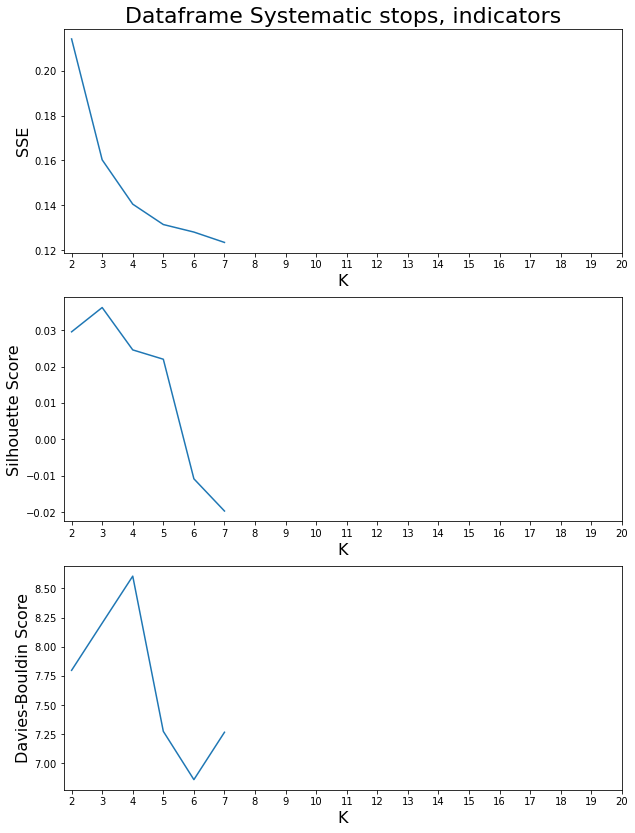

In [1267]:
plot_indicators("Systematic stops", 20, sse, sil, davies_bouldin)

In [1268]:
k = 3  # best k value
kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw")
kmeans.fit(df[hours])
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2])

SSE: 0.16027405551818172  - SILHOUETTE: 0.036277445732985


In [1269]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
clust_dict = dict(zip(bins, hist))
print(clust_dict)

{0: 445, 1: 230, 2: 352}


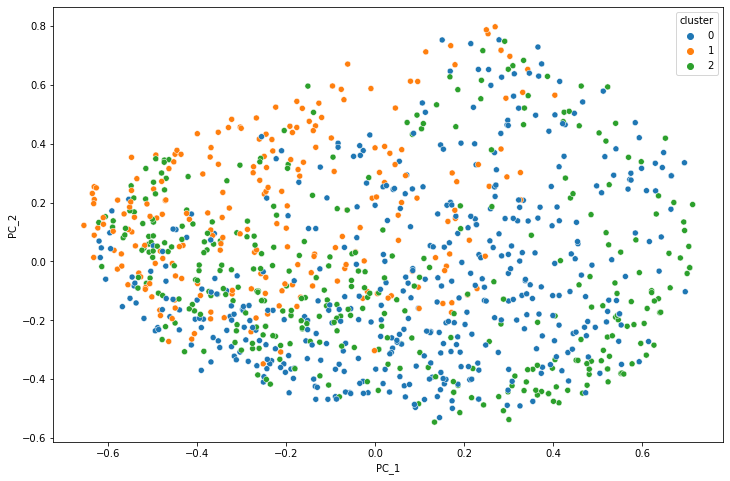

In [1270]:
pca = PCA(n_components=2)
scaler = TimeSeriesScalerMeanVariance()
df_pca = df[hours].copy()
df_pca.columns = df_pca.columns.astype(str)
df_pca_scaled = scaler.fit_transform(df_pca)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_pca), columns=['PC_1','PC_2'], index=df.index)
data_to_visualize['cluster'] = pd.Categorical(kmeans.labels_)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1",y="PC_2", hue="cluster", data=data_to_visualize);

In [1271]:
cluster_type = list()
cluster_colors = ["blue", "green", "orange"]#, "red"]#,"purple"]#,"pink","yellow",'brown']
for cluster in kmeans.cluster_centers_:
    cluster_type.append(cluster.mean())

cluster_type = pd.DataFrame(cluster_type, columns=["mean"])
cluster_type.sort_values("mean", inplace=True)
cluster_type["color"] = cluster_colors
cluster_type

,mean,color
2,0.070169,blue
1,0.116728,green
0,0.121558,orange


In [1272]:
def plot_basic_statistics(df, labels, columns):
    df_plot = pd.DataFrame(df, columns=columns, copy=True)
    df_plot['cluster'] = labels
    columns = df_plot.columns[0:-1]     
    means = []
    std = []
    label_s = 12
    fig = plt.figure(figsize=(19, 8))
    for i in np.unique(df_plot['cluster'].array):
        clust = df.loc[df_plot['cluster'] == i, df.columns==columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)
    legend = []
    for i in np.unique(df_plot['cluster'].array):
        cluster_color = cluster_type.loc[i, "color"]
        plt.plot(range(0, columns.shape[0]), means[i], marker='o', color=cluster_color)
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns, fontsize=label_s, rotation=89)
    plt.tight_layout()

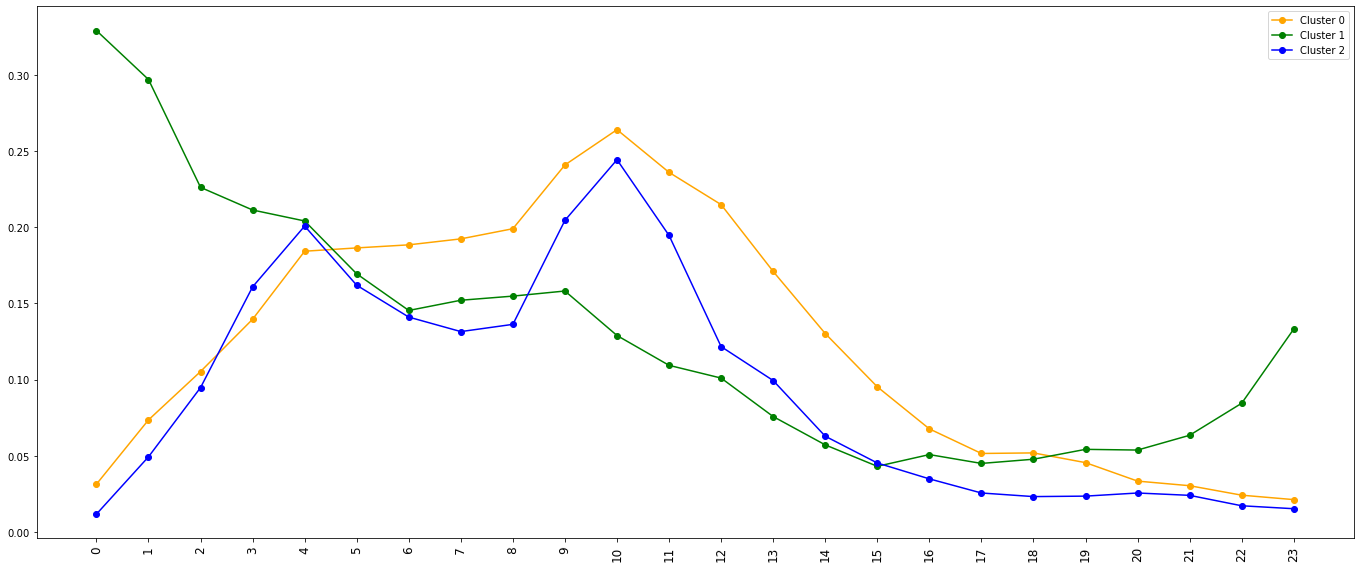

In [1273]:
clusters_stops = kmeans.labels_
plot_basic_statistics(df[hours], clusters_stops, df[hours].columns)

In [1108]:
clusters_stops

array([0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       0, 1, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 1,
       0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0,
       1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 0, 0, 1, 2, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 2,
       1, 1, 1, 2, 1])

In [1081]:
len(clusters_stops)

159

## Looking at data

In [1163]:
df_freq.set_index(['uid','location'],inplace=True)

In [1082]:
len(df_freq)

159

## Home detection with a rule-based method

In [1364]:
sp['duration'] = sp['leaving_datetime'] - sp['datetime']

In [1365]:
sp[sp['duration']>timedelta(hours=8)]

,uid,pos_hashed,datetime,lat,lng,tid,label,leaving_datetime,frequency,duration
15,0,wx4ewgd,2009-04-03 12:50:20,40.009698,116.315135,102_000,0,2009-04-04 06:47:36,6,0 days 17:57:16
496,1,wx4ews7,2008-10-26 08:57:31,40.013805,116.306498,56_001,0,2008-10-26 23:47:00,10,0 days 14:49:29
505,1,wx4ews7,2008-11-05 12:36:41,40.013789,116.306532,59_001,0,2008-11-05 23:44:30,10,0 days 11:07:49
649,2,wx4fbrs,2008-11-19 04:35:34,39.900442,116.384861,165_002,0,2008-11-19 13:45:14,7,0 days 09:09:40
781,2,wx4fbrt,2008-12-10 01:20:25,39.900012,116.386065,86_002,0,2008-12-10 09:53:12,28,0 days 08:32:47
...,...,...,...,...,...,...,...,...,...,...
17666,153,u151w56,2009-05-07 12:01:25,50.907845,4.486450,995_153,0,2009-05-07 21:17:48,1,0 days 09:16:23
17747,155,wx4epdn,2009-08-03 00:43:00,39.914072,116.353599,7_155,0,2009-08-03 09:33:16,1,0 days 08:50:16
18152,163,wx4gvq0,2009-04-19 04:15:25,40.068048,116.598246,339_163,0,2009-04-19 12:15:49,1,0 days 08:00:24
18282,163,wx4fcyx,2010-10-26 00:31:38,39.894420,116.453996,459_163,0,2010-10-26 09:41:03,1,0 days 09:09:25


In [1409]:
df_freq.set_index(['uid','location'],inplace=True)

<AxesSubplot:>

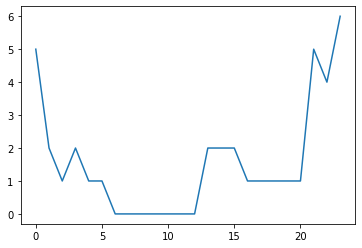

In [1414]:
df_freq.loc[(179,'wx4sn9g')].plot()

In [1178]:
trajs.loc[30]

duration    84 days 00:11:46
num_stop               847.0
Name: 30, dtype: object

In [1429]:
systematic_stops[systematic_stops['pos_hashed']=='wx4erxj']

,uid,pos_hashed,datetime,lat,lng,tid,label,leaving_datetime,frequency,duration,start_time,end_time
5600,52,wx4erxj,2008-07-10 15:08:55,39.984978,116.352574,103_052,0,2008-07-10 17:07:23,34,0 days 01:58:28,15,17
5606,52,wx4erxj,2008-06-13 11:16:36,39.984992,116.352606,14_052,0,2008-06-13 12:16:07,34,0 days 00:59:31,11,12
5613,52,wx4erxj,2008-05-31 15:32:24,39.985029,116.352581,21_052,0,2008-05-31 17:29:00,34,0 days 01:56:36,15,17
5621,52,wx4erxj,2008-05-27 19:36:27,39.985052,116.352768,27_052,0,2008-05-27 20:37:57,34,0 days 01:01:30,19,20
5628,52,wx4erxj,2008-06-03 12:48:26,39.984989,116.352684,30_052,0,2008-06-03 13:16:58,34,0 days 00:28:32,12,13
5629,52,wx4erxj,2008-06-03 13:21:24,39.984990,116.352644,30_052,0,2008-06-03 17:20:53,34,0 days 03:59:29,13,17
5635,52,wx4erxj,2008-06-06 12:24:34,39.985031,116.352720,40_052,0,2008-06-06 16:03:00,34,0 days 03:38:26,12,16
5636,52,wx4erxj,2008-06-06 16:03:14,39.985179,116.352705,40_052,0,2008-06-06 16:46:24,34,0 days 00:43:10,16,16
5638,52,wx4erxj,2008-06-04 21:58:47,39.984943,116.352815,43_052,0,2008-06-04 22:23:33,34,0 days 00:24:46,21,22
5639,52,wx4erxj,2008-06-04 22:23:33,39.985032,116.352640,43_052,0,2008-06-05 16:34:25,34,0 days 18:10:52,22,16


In [1420]:
df_freq.loc[52]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
location,,,,,,,,,,,,,,,,,,,,,
wx4eqtw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0
wx4ernk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0
wx4g2zq,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
wx4erzf,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
wx4erxj,7.0,7.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,...,7.0,11.0,11.0,9.0,5.0,3.0,4.0,7.0,10.0,11.0
wx4g8zq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wx4ern0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wx4ej0y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,...,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
wx4g1hj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
geohash2.decode_exactly('wx4ex1f')

(40.00053405761719, 116.32667541503906, 0.0006866455078125, 0.0006866455078125)

# TO DO:

1) entropy per raw

2) fasce orarie

3) work/home/other prob

4) normalize weight -> the sum must be 1